In [ ]:
%pwd

'/content'

In [ ]:
!pip install import_ipynb --quiet
!git clone https://github.com/gmshroff/aml-public.git
%cd aml-public

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00
Cloning into 'aml-public'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 64 (delta 8), reused 14 (delta 3), pack-reused 43
Receiving objects: 100% (64/64), 4.04 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/aml-public


In [ ]:
%pwd

'/content/aml-public'

### Imports

In [1]:
import requests
import pandas as pd
import torch
import torch
import random
import math, time, os
import pandas as pd
from matplotlib import pyplot as plt
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import numpy as np
import numpy as np
import torch
from torch import nn
from torch import optim
from IPython import display
import psutil, gc
# utils.hide_toggle('Imports 2')
from torch.utils.data import Dataset
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import math
from numpy import sin, pi
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
import pathlib
from PIL import Image
from PIL.ImageOps import invert
from IPython import display
from time import sleep
import pickle
from matplotlib import pyplot as plt

In [2]:
def hide_toggle(x):
    return
class MyDS(Dataset):
    def __init__(self, X,y,task='classification'):
        self.samples = torch.Tensor(X)
        if task=='classification': self.labels = torch.LongTensor(y)
        elif task=='regression': self.labels = torch.Tensor(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (self.samples[idx],self.labels[idx])
#hide_toggle('Class MyDS')

def euclideanDataset(n_samples=1000,n_classes=2,class_sep=2.0,n_features=5,batch_size=1,
                     n_clusters_per_class=1):
    X,y = skds.make_classification(n_samples=n_samples,n_classes=n_classes,
                                   class_sep=class_sep,n_features=n_features,
                                 n_informative=n_features,n_redundant=0,
                                 n_repeated=0,n_clusters_per_class=n_clusters_per_class)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    ds = MyDS(X_train,y_train)
    ds_hold = MyDS(X_test,y_test)
    dsloader = torch.utils.data.DataLoader(dataset=ds,batch_size=batch_size,shuffle=True)
    return ds,ds_hold,dsloader
#hide_toggle('Function euclideanDataset')

In [3]:
import psutil
def get_memory_usage():
    mem = psutil.virtual_memory()
    return f'{mem.used / 1024 ** 3} of {mem.total / 1024 ** 3}; {mem.available / 1024 ** 3} available'

In [4]:
def accuracy(Net,X_test,y_test,verbose=True):
    Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    Net.train()
    return accuracy
def accuracy_variable(Net,data):
    step=0
    acc=0
    for (X,y) in data:
            y_pred = Net(X)
            step+=1
            acc+=accuracy(Net,X,y,verbose=False)
    a = acc/step
    return a
def TrainVals(Net,X_vals,y_vals,epochs=20,lr=5e-2,Loss=nn.NLLLoss(),verbose=False,device='cpu',batch_size=32):
    #optimizer = optim.Adam(Net.parameters(),lr=lr)
    losses = []
    accs = []
    Net.to(device)
    N=X_vals.shape[0]
    n_batches=int(N/batch_size)
    for e in range(epochs):
        step=0
        tot_loss=0.0
        start_time = time.time()
        acc=0.0
        for idx in range(0,N,n_batches):
            if idx+32>1000: start,end=idx,N
            else: start,end=idx,idx+batch_size
            X,y=torch.tensor(X_vals[start:end],dtype=torch.float32),torch.tensor(y_vals[start:end],dtype=torch.int64)
            X=X.to(device)
            y=y.to(device)
            y_pred = Net(X)
            loss = Loss(y_pred,y)
            Net.optimizer.zero_grad()
            loss.backward()
            Net.optimizer.step()
            step+=1
            tot_loss+=loss
            if verbose: acc+=accuracy(Net,X,y,verbose=False)
        end_time = time.time()
        t = end_time-start_time
        l = tot_loss.item()/step
        if verbose:
            a = acc/step
            accs += [a]
        losses += [l]
        if verbose:
            print('Epoch  % 2d Loss: %2.5e Accuracy: %2.5f Epoch Time: %2.5f' %(e,l,a,t))
            print(get_memory_usage())
            gc.collect()
            display.clear_output(wait=True)
    return Net,losses,accs
# utils.hide_toggle('Function Train')

In [5]:
class MLP(nn.Module):
    def __init__(self,dims=[5,3,2],task='classification',lr=1e-3,weight_decay=0):
        super(MLP,self).__init__()
        self.dims=dims
        self.n = len(self.dims)-1
        self.task=task
        self.layers=nn.ModuleList()
        for i in range(self.n-1):
            self.layers.append(nn.Linear(dims[i],dims[i+1]))
            self.layers.append(nn.ReLU())
        if task=='classification':
            self.layers.append(nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(nn.LogSoftmax(dim=1))
        elif task=='regression':
            self.layers.append(nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(nn.Linear(dims[i+2],1))
        else: self.layers.append(nn.Linear(dims[i+1],dims[i+2]))
        self.optimizer = optim.Adam(self.parameters(),lr=lr,weight_decay=weight_decay)
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return(x)
# utils.hide_toggle('Class MLP')

In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,lr):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.input_size=input_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        self.logsoft = nn.LogSoftmax(dim=-1)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        if self.input_size==1: x=x.unsqueeze(-1)
        h = self.rnn(x)[0]
        x = self.linear(h)
        x = self.logsoft(x)
        x=x[:,-1,:]
        return x

In [7]:
def Train(Net,data,epochs=20,lr=5e-2,Loss=nn.NLLLoss(),verbose=False,device='cpu',
          val_ds=None,plot_accs=False,plot_losses=False):
    #optimizer = optim.Adam(Net.parameters(),lr=lr)
    losses = []
    val_losses=[]
    accs = []
    val_accL=[]
    Net.to(device)
    for e in range(epochs):
        step=0
        tot_loss=0.0
        start_time = time.time()
        acc=0.0
        for (X,y) in data:
            X=X.to(device)
            y=y.to(device)
            y_pred = Net(X)
            loss = Loss(y_pred,y)
            Net.optimizer.zero_grad()
            loss.backward()
            Net.optimizer.step()
            step+=1
            tot_loss+=loss
            if verbose: acc+=accuracy(Net,X,y,verbose=False)
        end_time = time.time()
        t = end_time-start_time
        l = tot_loss.item()/step
        if verbose:
            a = acc/step
            accs += [a]
        losses += [l]
        if verbose:
            display.clear_output(wait=True)
            print('Epoch  % 2d Loss: %2.5e Accuracy: %2.5f Epoch Time: %2.5f' %(e,l,a,t))
        if plot_accs and val_ds is not None:
            val_accL+=[accuracy(Net,val_ds.samples,val_ds.labels,verbose=False)]
            plt.plot(np.array(val_accL),color='red')
            plt.plot(np.array(accs),color='blue')
            plt.show()
        if plot_losses and val_ds is not None:
            val_losses+=[Loss(Net(torch.tensor(val_ds.samples)),torch.tensor(val_ds.labels)).detach().numpy()]
            plt.plot(val_losses,color='red')
            plt.plot(losses,color='blue')
            plt.show()
    return Net,losses,accs

### Data imports and reads

In [16]:
df = pd.read_csv('df_synA_test_hard_shuffled_sample.csv',on_bad_lines='skip')
df = df.dropna()

In [17]:
class_values=list(df.era.unique())
class_values

[17, 14, 0, 15, 3, 1, 23, 16, 22, 18, 8, 7]

In [18]:
def encode(v,class_values=class_values):
    return class_values.index(v)

In [19]:
df['era_label']=df['era'].apply(encode)
df['era_label'].unique()
df=df.sample(frac=1.0)
df

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,era,target_10_val,target_5_val,data_type,era_label
34216,1.00,1.00,1.0,1.00,0.0,1.00,1.00,1.00,0.75,0.25,...,0.25,0.75,0.75,138,411,3,0.75,0.75,validation,4
162131,1.00,1.00,1.0,0.75,0.0,1.00,1.00,0.50,0.00,1.00,...,0.00,0.00,0.25,109,464,14,0.00,0.00,validation,1
12384,0.00,0.00,0.0,0.00,0.0,0.00,0.00,1.00,1.00,0.00,...,0.50,0.25,0.50,135,415,7,0.75,0.00,validation,11
65822,0.00,0.00,0.0,0.00,0.0,0.25,0.25,0.25,0.50,0.25,...,0.75,0.75,0.00,89,442,17,1.00,1.00,validation,0
98781,0.00,0.00,0.0,0.00,0.0,0.25,0.00,0.25,0.25,1.00,...,0.50,0.25,0.25,79,544,14,0.75,0.00,validation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241306,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.25,0.50,0.25,...,1.00,1.00,1.00,119,549,7,1.00,1.00,validation,11
234803,1.00,1.00,1.0,1.00,0.0,0.75,1.00,0.75,0.25,0.00,...,0.25,0.50,1.00,107,382,18,0.00,0.00,validation,9
59571,0.25,0.25,0.0,0.00,0.0,0.25,0.00,0.25,0.75,0.75,...,0.00,0.25,0.00,127,400,16,0.75,0.00,validation,7
230962,1.00,1.00,1.0,1.00,0.0,1.00,0.75,0.75,0.75,0.75,...,0.00,0.00,0.25,103,506,14,0.00,0.00,validation,1


In [20]:
df_train=df.iloc[0:(len(df)*7)//10]
df_test = df.iloc[(len(df)*7)//10:]

In [21]:
x_train=df_train.iloc[:,0:-6].values
y_train=df_train.iloc[:,-1].values
x_test=df_test.iloc[:,0:-6].values
y_test=df_test.iloc[:,-1].values

In [22]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((174720, 25), (174720,), (74880, 25), (74880,))

### Training on noisy data

In [23]:
ds_train=MyDS(x_train,y_train)

In [24]:
net=MLP(dims=[25,64,32,12])
dloader=torch.utils.data.DataLoader(dataset=ds_train,batch_size=32,shuffle=True)
net,losses,accs=Train(net,dloader,epochs=10,verbose=True)

Epoch   9 Loss: 1.36406e+00 Accuracy: 0.49799 Epoch Time: 14.74987


In [25]:
ds_test=MyDS(x_test,y_test)

In [26]:
accuracy(net,ds_train.samples,ds_train.labels)

85664.0 174720


0.49029304029304027

### Removing noise using AdaBoost

In [27]:
original_df = df.copy()

In [28]:
X = df.iloc[:,0:-6].values
y = df.iloc[:,-1].values

In [29]:
del df

In [30]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100)
ada.fit(X, y)
importances = ada.feature_importances_
indices = np.argsort(importances)[::-1]
n_top_features = int(0.8 * len(indices))
top_feature_indices = indices[:n_top_features]

In [31]:
X_selected = X[:, top_feature_indices]
X_selected_df = pd.DataFrame(X_selected)
X_selected_df['target'] = y

In [32]:
X_selected.shape

(249600, 20)

In [33]:
X_selected_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,1.00,138.0,0.25,1.00,0.50,0.75,1.00,1.00,0.75,1.0,...,0.75,0.25,1.00,1.00,0.75,0.50,0.75,1.00,0.25,4
1,1.00,109.0,0.00,1.00,1.00,0.00,0.50,1.00,0.25,1.0,...,0.00,1.00,0.75,1.00,0.00,0.50,0.00,0.00,0.00,1
2,0.00,135.0,0.00,0.00,0.00,1.00,1.00,0.00,0.50,0.0,...,0.25,0.00,0.00,0.00,1.00,0.25,1.00,0.50,0.00,11
3,0.25,89.0,0.75,0.25,0.75,0.00,0.25,0.00,0.00,0.0,...,0.75,0.25,0.00,0.00,0.25,0.25,0.50,0.25,1.00,0
4,0.00,79.0,0.00,0.25,0.00,0.75,0.25,0.00,0.25,0.0,...,0.25,1.00,0.00,0.00,0.00,0.25,0.25,0.25,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249595,0.00,119.0,0.75,0.00,0.00,0.75,0.25,0.00,1.00,0.0,...,1.00,0.25,0.00,0.00,0.75,0.00,0.50,0.75,0.00,11
249596,1.00,107.0,0.50,0.75,0.25,1.00,0.75,1.00,1.00,1.0,...,0.50,0.00,1.00,1.00,1.00,0.75,0.25,0.75,1.00,9
249597,0.00,127.0,0.00,0.25,0.00,0.50,0.25,0.25,0.00,0.0,...,0.25,0.75,0.00,0.25,0.00,0.50,0.75,0.50,0.25,7
249598,0.75,103.0,0.00,1.00,0.50,1.00,0.75,1.00,0.25,1.0,...,0.00,0.75,1.00,1.00,0.75,1.00,0.75,0.75,1.00,1


In [34]:
df_train=X_selected_df.iloc[0:(len(X)*7)//10]
df_test = X_selected_df.iloc[(len(X)*7)//10:]
x_train=df_train.iloc[:,:-1].values
y_train=df_train.iloc[:,-1].values
x_test=df_test.iloc[:,:-1].values
y_test=df_test.iloc[:,-1].values

Epoch   19 Loss: 1.36202e+00 Accuracy: 0.50163 Epoch Time: 14.58472


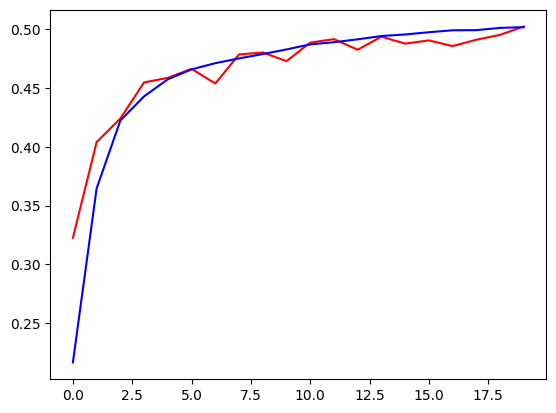

In [35]:
ds_train=MyDS(x_train,y_train)
net=MLP(dims=[20,64,32,12])
ds_test=MyDS(x_test,y_test)
dloader=torch.utils.data.DataLoader(dataset=ds_train,batch_size=32,shuffle=True)
net,losses,accs=Train(net,dloader,epochs=20,verbose=True,plot_accs=True,val_ds=ds_test)

In [36]:
ds_test=MyDS(x_test,y_test)
accuracy(net,ds_train.samples,ds_train.labels)

88297.0 174720


0.5053628663003663

### Using bagging

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

bagging_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=0)
bagging_model.fit(X, y)
importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
n_top_features = int(0.8 * len(indices))
top_feature_indices = indices[:n_top_features]
X_selected = X[:, top_feature_indices]

In [38]:
X_selected_df = pd.DataFrame(X_selected)
X_selected_df['target'] = y

In [39]:
df_train=X_selected_df.iloc[0:(len(X)*7)//10]
df_test = X_selected_df.iloc[(len(X)*7)//10:]
x_train=df_train.iloc[:,:-1].values
y_train=df_train.iloc[:,-1].values
x_test=df_test.iloc[:,:-1].values
y_test=df_test.iloc[:,-1].values

Epoch   19 Loss: 1.42140e+00 Accuracy: 0.47748 Epoch Time: 14.56430


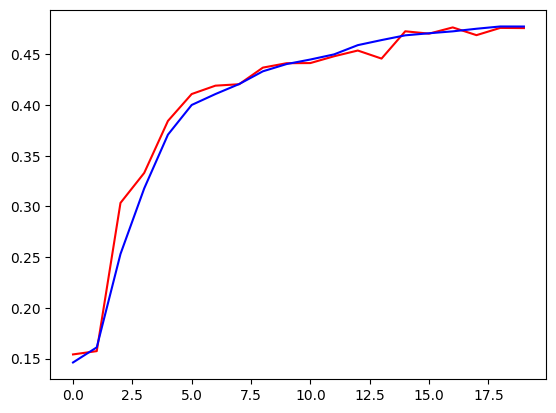

In [40]:
ds_train=MyDS(x_train,y_train)
net=MLP(dims=[20,64,32,12])
ds_test=MyDS(x_test,y_test)
dloader=torch.utils.data.DataLoader(dataset=ds_train,batch_size=32,shuffle=True)
net,losses,accs=Train(net,dloader,epochs=20,verbose=True,plot_accs=True,val_ds=ds_test)

In [41]:
ds_test=MyDS(x_test,y_test)
accuracy(net,ds_train.samples,ds_train.labels)

83314.0 174720


0.47684294871794874

### Bagging + multiple MLPs

In [42]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
n_mlps = 5
mlps = []
predictions = []
for i in range(n_mlps):
    mlp = MLP(dims=[20, 64, 32, 12])
    mlp, _, _ = Train(mlp, dloader, epochs=20, verbose=False)
    mlps.append(mlp)
    y_pred = mlp(torch.tensor(x_test, dtype=torch.float)).detach().numpy()
    predictions.append(y_pred)
mean_predictions = np.mean(predictions, axis=0)
final_predictions = np.argmax(mean_predictions, axis=1)
ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

Ensemble Accuracy: 0.49727564102564104
